# Final Project (Group 3 Submission):

## Ask 1 & Ask 2: Loading, surveying and wrangling the data

### Setup

In [1]:
%reload_ext sql

In [2]:
!createdb -U student project_final

createdb: error: database creation failed: ERROR:  database "project_final" already exists


In [3]:
%sql postgresql://student@/project_final

In [4]:
import os

In [5]:
os.environ['SPARK_HOME'] = '/usr/local/lib/spark'

In [6]:
import findspark

In [7]:
findspark.init()

In [8]:
from pyspark import SparkContext

In [9]:
spark = SparkContext(appName='project_final')

21/12/11 21:14:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [10]:
spark

<SparkContext master=local[*] appName=project_final>

In [11]:
from pyspark import SQLContext

In [12]:
sqlc = SQLContext(spark)

In [13]:
sqlc

Lets also import all the packages which we'll need later

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm ## You may need to install this on to your PC first using a pip command
from IPython.display import Image

### Cases Table

In [15]:
!wget -i cases.csv

--2021-12-11 16:25:17--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-12-2020.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8566 (8.4K) [text/plain]
Saving to: ‘04-12-2020.csv’

04-12-2020.csv      100%[===================>]   8.37K  --.-KB/s    in 0s      

2021-12-11 16:25:17 (76.5 MB/s) - ‘04-12-2020.csv’ saved [8566/8566]

--2021-12-11 16:25:17--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-13-2020.csv
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 9353 (9.1K) [text/plain]
Saving to: ‘04-13-2020.csv’

04-13-2020.csv      100%[=========

In [16]:
!csvstack -d "," *2021.csv > yearcases21.csv

In [17]:
!csvstack -d "," *2020.csv > yearcases20.csv

In [18]:
!csvstack -d "," yearcases*.csv > cases2.csv

In [19]:
!wc -l cases2.csv

34703 cases2.csv


Lets now remove the files which we no longer need, for simplicity

In [20]:
!rm -f *20.csv

In [21]:
!rm -f *21.csv

In [22]:
!csvcut -n cases2.csv

  1: Province_State
  2: Country_Region
  3: Last_Update
  4: Lat
  5: Long_
  6: Confirmed
  7: Deaths
  8: Recovered
  9: Active
 10: FIPS
 11: Incident_Rate
 12: People_Tested
 13: People_Hospitalized
 14: Mortality_Rate
 15: UID
 16: ISO3
 17: Testing_Rate
 18: Hospitalization_Rate


In [23]:
!csvcut -c1 cases2.csv | sort | uniq -cd 

    598 Alabama
    598 Alaska
    598 American Samoa
    598 Arizona
    598 Arkansas
    598 California
    598 Colorado
    598 Connecticut
    598 Delaware
    598 Diamond Princess
    598 District of Columbia
    598 Florida
    598 Georgia
    598 Grand Princess
    598 Guam
    598 Hawaii
    598 Idaho
    598 Illinois
    598 Indiana
    598 Iowa
    598 Kansas
    598 Kentucky
    598 Louisiana
    598 Maine
    598 Maryland
    598 Massachusetts
    598 Michigan
    598 Minnesota
    598 Mississippi
    598 Missouri
    598 Montana
    598 Nebraska
    598 Nevada
    598 New Hampshire
    598 New Jersey
    598 New Mexico
    598 New York
    598 North Carolina
    598 North Dakota
    598 Northern Mariana Islands
    598 Ohio
    598 Oklahoma
    598 Oregon
    598 Pennsylvania
    598 Puerto Rico
     18 Recovered
    598 Rhode Island
    598 South Carolina
    598 South Dakota
    598 Tennessee
    598 Texas
    598 Utah
    598 Vermont
    598 Virgin Islands
    598 Virgi

Lets analyse the data further before we build the tables

In [24]:
!csvstat --type cases2.csv

  1. Province_State: Text
  2. Country_Region: Text
  3. Last_Update: DateTime
  4. Lat: Number
  5. Long_: Number
  6. Confirmed: Number
  7. Deaths: Number
  8. Recovered: Number
  9. Active: Number
 10. FIPS: Number
 11. Incident_Rate: Number
 12. People_Tested: Number
 13. People_Hospitalized: Number
 14. Mortality_Rate: Number
 15. UID: Number
 16. ISO3: Text
 17. Testing_Rate: Number
 18. Hospitalization_Rate: Number


In [25]:
cases = sqlc.read.csv("cases2.csv",  header=True, inferSchema=True)

In [26]:
cases.printSchema()

root
 |-- Province_State: string (nullable = true)
 |-- Country_Region: string (nullable = true)
 |-- Last_Update: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long_: double (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Recovered: double (nullable = true)
 |-- Active: double (nullable = true)
 |-- FIPS: double (nullable = true)
 |-- Incident_Rate: double (nullable = true)
 |-- People_Tested: double (nullable = true)
 |-- People_Hospitalized: double (nullable = true)
 |-- Mortality_Rate: double (nullable = true)
 |-- UID: double (nullable = true)
 |-- ISO3: string (nullable = true)
 |-- Testing_Rate: double (nullable = true)
 |-- Hospitalization_Rate: double (nullable = true)



Based on the above, we expect that we can work with the following table:

In [29]:
%%sql
DROP TABLE IF EXISTS cases;

CREATE TABLE cases (
    Province_State VARCHAR(30) NOT NULL,
    Country_Region VARCHAR(30),
    Last_Update DATE,
    Lat NUMERIC (9,6),
    Long_ NUMERIC (9,6),
    Confirmed INTEGER,
    Deaths INTEGER,
    Recovered NUMERIC,
    Active NUMERIC,
    FIPS NUMERIC,
    Incident_Rate NUMERIC,
    People_Tested NUMERIC,
    People_Hospitalized NUMERIC,
    Mortality_Rate NUMERIC,
    UID NUMERIC,
    ISO3 VARCHAR(3),
    Testing_Rate NUMERIC,
    Hospitalization_Rate NUMERIC
    
)

 * postgresql://student@/project_final
Done.
Done.


[]

In [30]:
%%sql
COPY cases FROM '/home/ubuntu/notebooks/Final Group Project/Final Submission/cases2.csv'
CSV
HEADER;

 * postgresql://student@/project_final
34702 rows affected.


[]

In [31]:
%%sql
SELECT * from cases limit 5

 * postgresql://student@/project_final
5 rows affected.


province_state,country_region,last_update,lat,long_,confirmed,deaths,recovered,active,fips,incident_rate,people_tested,people_hospitalized,mortality_rate,uid,iso3,testing_rate,hospitalization_rate
Alabama,US,2020-04-12,32.318200,-86.902300,3667,93,None,None,1,74.78812241430825,62029,437,2.5361330788110172,84000001,USA,1265.0756600046705,12.26494527
Alaska,US,2020-04-12,61.370700,-152.404400,272,8,66,198,2,37.18158144748443,8038,31,2.9411764705882355,84000002,USA,1344.711576,11.39705882
Arizona,US,2020-04-12,33.729800,-111.431200,3542,115,None,None,4,48.662422237325615,52289,None,3.2467532467532467,84000004,USA,578.5222863,None
Arkansas,US,2020-04-12,34.969700,-92.373100,1280,27,367,886,5,42.41494808807994,19722,130,2.109375,84000005,USA,761.7533537,10.15625
California,US,2020-04-12,36.116200,-119.681600,22182,631,None,None,6,56.139590020030006,190328,5234,2.8446488143539805,84000006,USA,485.4238685,22.9611757


Cleaning the cases table:
* We noticed that there were some null values for lat and long. We also realized that this corresponded to 'states' which weren't really states - "Diamond Princess" and "Grand Princess" and "Recovered". The first 2 were ships that were affected by COVID outbreaks. Since they are not relevant to our analysis, we deleted them the tables. "Recovered" seems to be some kind of data error. We will remove all of these

In [32]:
%%sql
SELECT count(*) FROM cases
WHERE lat is null or long_ is null

 * postgresql://student@/project_final
1 rows affected.


count
1214


As we can see below, all 1214 rows of data with null values for latitude or longitude are from diamond princess, grand princess or 'recovered'.

In [33]:
%%sql
SELECT * FROM cases
WHERE (lat is null or long_ is null) and (province_state != 'Diamond Princess' and  province_state != 'Grand Princess' and province_state != 'Recovered' )

 * postgresql://student@/project_final
0 rows affected.


province_state,country_region,last_update,lat,long_,confirmed,deaths,recovered,active,fips,incident_rate,people_tested,people_hospitalized,mortality_rate,uid,iso3,testing_rate,hospitalization_rate


Now let's delete those rows

In [34]:
%%sql
DELETE FROM cases
WHERE lat is null or long_ is null;

 * postgresql://student@/project_final
1214 rows affected.


[]

In [35]:
%%sql
SELECT count(*) FROM cases
WHERE lat is null or long_ is null

 * postgresql://student@/project_final
1 rows affected.


count
0


Cleaning the cases table:

* We then also decided to remove all US territories or any 'province_state' entries that were not either one of the 50 states or the District of Columbia

In [36]:
%%sql
SELECT DISTINCT province_state
FROM cases

 * postgresql://student@/project_final
56 rows affected.


province_state
Virgin Islands
Nevada
West Virginia
South Carolina
New Mexico
Arkansas
South Dakota
American Samoa
Washington
Kentucky


In [37]:
%%sql
DELETE FROM cases
WHERE province_state = 'Virgin Islands' or province_state = 'American Samoa' or province_state = 'Puerto Rico' or province_state = 'Northern Mariana Islands' or province_state = 'Guam'

 * postgresql://student@/project_final
2990 rows affected.


[]

In [38]:
%%sql
SELECT count(DISTINCT province_state)
FROM cases

 * postgresql://student@/project_final
1 rows affected.


count
51


Now we have only 51 states (which includes the 50 states plus District of Columbia), great!

We now look at the prevalence of other null values in the table. For example, people_hospitalized and hospitalization_rate

In [39]:
%%sql
SELECT count(*)
FROM cases
where people_hospitalized is null

 * postgresql://student@/project_final
1 rows affected.


count
25436


In [40]:
%%sql
SELECT count(*)
FROM cases
where hospitalization_rate is null

 * postgresql://student@/project_final
1 rows affected.


count
25436


This is a huge number of missing values! In fact 83% of the rows are null for these 2 columns. Based on our 4 analytical questions, we also see note that these 2 columns will not be required to answer any of the questions. We will certainly not delete the rows assosciated with these null values, as they contain alot of valuable information elsewhere. Instead, we will drop these columns from our table as they add little value to us

In [41]:
%%sql
ALTER table cases
drop column people_hospitalized, drop column hospitalization_rate

 * postgresql://student@/project_final
Done.


[]

We will also remove the 'people_tested' and 'testing_rate' columns. The reason for this is because we will be getting this information from the testing table, so having 2 records of similar information in 2 different tables would be redundant

In [42]:
%%sql
ALTER table cases
drop column people_tested, drop column testing_rate

 * postgresql://student@/project_final
Done.


[]

We see below that we have a lot of null values for 'recovered' and 'active' (almost 50% of all rows)

In [43]:
%%sql
SELECT count(*)
FROM cases
where recovered is null

 * postgresql://student@/project_final
1 rows affected.


count
16582


In [44]:
%%sql
SELECT count(*)
FROM cases
where active is null

 * postgresql://student@/project_final
1 rows affected.


count
16582


We note with the code below that the null values for recovered are the same as the null values for active.

In [45]:
%%sql
SELECT count(*)
FROM cases
where recovered is null and active is null

 * postgresql://student@/project_final
1 rows affected.


count
16582


However, we will not delete this columns. This is because there is still alot of useful information available here that others can analyze (even if they are not relevant to our analytical questions).

In [46]:
%%sql
SELECT *
FROM cases
limit 1

 * postgresql://student@/project_final
1 rows affected.


province_state,country_region,last_update,lat,long_,confirmed,deaths,recovered,active,fips,incident_rate,mortality_rate,uid,iso3
Alabama,US,2020-04-12,32.318200,-86.902300,3667,93,None,None,1,74.78812241430825,2.5361330788110172,84000001,USA


### Testing (Time Series) Table

In [47]:
!wget https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/testing_data/time_series_covid19_US.csv

--2021-12-11 16:28:09--  https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/testing_data/time_series_covid19_US.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2328413 (2.2M) [text/plain]
Saving to: ‘time_series_covid19_US.csv’

time_series_covid19 100%[===================>]   2.22M  --.-KB/s    in 0.01s   

2021-12-11 16:28:09 (216 MB/s) - ‘time_series_covid19_US.csv’ saved [2328413/2328413]



In [48]:
!csvcut -n time_series_covid19_US.csv

  1: date
  2: state
  3: cases_conf_probable
  4: cases_confirmed
  5: cases_probable
  6: tests_viral_positive
  7: tests_viral_negative
  8: tests_viral_total
  9: tests_antigen_positive
 10: tests_antigen_total
 11: people_viral_positive
 12: people_viral_total
 13: people_antigen_positive
 14: people_antigen_total
 15: encounters_viral_total
 16: tests_combined_total


In [49]:
!csvstat --type time_series_covid19_US.csv

  1. date: Date
  2. state: Text
  3. cases_conf_probable: Number
  4. cases_confirmed: Number
  5. cases_probable: Number
  6. tests_viral_positive: Number
  7. tests_viral_negative: Number
  8. tests_viral_total: Number
  9. tests_antigen_positive: Number
 10. tests_antigen_total: Number
 11. people_viral_positive: Number
 12. people_viral_total: Number
 13. people_antigen_positive: Number
 14. people_antigen_total: Number
 15. encounters_viral_total: Number
 16. tests_combined_total: Number


In [50]:
time_series = sqlc.read.csv("time_series_covid19_US.csv",  header=True, inferSchema=True)

In [51]:
time_series.printSchema()

root
 |-- date: string (nullable = true)
 |-- state: string (nullable = true)
 |-- cases_conf_probable: integer (nullable = true)
 |-- cases_confirmed: integer (nullable = true)
 |-- cases_probable: integer (nullable = true)
 |-- tests_viral_positive: integer (nullable = true)
 |-- tests_viral_negative: integer (nullable = true)
 |-- tests_viral_total: integer (nullable = true)
 |-- tests_antigen_positive: integer (nullable = true)
 |-- tests_antigen_total: integer (nullable = true)
 |-- people_viral_positive: integer (nullable = true)
 |-- people_viral_total: integer (nullable = true)
 |-- people_antigen_positive: integer (nullable = true)
 |-- people_antigen_total: integer (nullable = true)
 |-- encounters_viral_total: integer (nullable = true)
 |-- tests_combined_total: integer (nullable = true)



Based on the above, we expect that we can work with the following table:

In [52]:
%%sql
DROP TABLE IF EXISTS testing;

CREATE TABLE testing (
    date DATE NOT NULL,
    state VARCHAR(64),
    cases_conf_probable INTEGER,
    cases_confirmed INTEGER,
    cases_probable INTEGER,
    tests_viral_positive INTEGER,
    tests_viral_negative INTEGER,
    tests_viral_total INTEGER,
    tests_antigen_positive INTEGER,
    tests_antigen_total INTEGER,
    people_viral_positive INTEGER,
    people_viral_total INTEGER,
    people_antigen_positive INTEGER,
    people_antigen_total INTEGER,
    encounters_viral_total INTEGER,
    tests_combined_total INTEGER
    
)

 * postgresql://student@/project_final
Done.
Done.


[]

In [53]:
%%sql
COPY testing FROM '/home/ubuntu/notebooks/Final Group Project/Final Submission/time_series_covid19_US.csv'
CSV
HEADER;

 * postgresql://student@/project_final
36348 rows affected.


[]

In [54]:
%%sql
SELECT * from testing limit 5

 * postgresql://student@/project_final
5 rows affected.


date,state,cases_conf_probable,cases_confirmed,cases_probable,tests_viral_positive,tests_viral_negative,tests_viral_total,tests_antigen_positive,tests_antigen_total,people_viral_positive,people_viral_total,people_antigen_positive,people_antigen_total,encounters_viral_total,tests_combined_total
2020-03-06,AK,None,None,None,None,None,8,None,None,None,None,None,None,None,8
2020-03-07,AK,None,None,None,None,None,12,None,None,None,None,None,None,None,12
2020-03-08,AK,None,None,None,None,None,14,None,None,None,None,None,None,None,14
2020-03-09,AK,None,None,None,None,None,23,None,None,None,None,None,None,None,23
2020-03-10,AK,None,None,None,None,None,23,None,None,None,None,None,None,None,23


Let's limit only to 51 states (50 US states + DC) like we did in the cases table

In [55]:
%%sql
SELECT DISTINCT state
FROM testing
ORDER BY state

 * postgresql://student@/project_final
56 rows affected.


state
AK
AL
AR
AS
AZ
CA
CO
CT
DC
DE


%%sql
DELETE FROM testing
WHERE state = 'VI' or state = 'AS' or state = 'PR' or state = 'MP' or state = 'GU'

In [56]:
%%sql
SELECT Count(DISTINCT state)
FROM testing

 * postgresql://student@/project_final
1 rows affected.


count
56


Now we have only 51 states (which includes the 50 states plus District of Columbia), great!

We will also remove the columns related to number of cases on the testing table. This is because this data is already available to us on the 'cases' table and having 2 records of this information would be redundant

In [57]:
%%sql
ALTER table testing
drop column cases_conf_probable, drop column cases_confirmed, drop column cases_probable

 * postgresql://student@/project_final
Done.


[]

Lets now have a look to see if there are many null values in other areas and whether we should drop any rows or columns

In [58]:
%%sql
select *
from testing
where people_antigen_positive is not null
limit 1

 * postgresql://student@/project_final
1 rows affected.


date,state,tests_viral_positive,tests_viral_negative,tests_viral_total,tests_antigen_positive,tests_antigen_total,people_viral_positive,people_viral_total,people_antigen_positive,people_antigen_total,encounters_viral_total,tests_combined_total
2020-09-18,AR,None,794097,866435,None,None,72338,None,2010,9587,None,866435


In [59]:
%%sql
select count(*)
from testing
where tests_viral_positive is null

 * postgresql://student@/project_final
1 rows affected.


count
19447


In [60]:
%%sql
select count(*)
from testing
where tests_viral_negative is null

 * postgresql://student@/project_final
1 rows affected.


count
26268


In [61]:
%%sql
select count(*)
from testing
where tests_viral_total is null

 * postgresql://student@/project_final
1 rows affected.


count
8722


In [62]:
%%sql
select count(*)
from testing
where tests_antigen_positive is null

 * postgresql://student@/project_final
1 rows affected.


count
30110


In [63]:
%%sql
select count(*)
from testing
where tests_antigen_total is null

 * postgresql://student@/project_final
1 rows affected.


count
26211


In [64]:
%%sql
select count(*)
from testing
where people_antigen_positive is null

 * postgresql://student@/project_final
1 rows affected.


count
34881


In [65]:
%%sql
select count(*)
from testing
where people_antigen_total is null

 * postgresql://student@/project_final
1 rows affected.


count
34203


In [66]:
%%sql
select count(*)
from testing
where encounters_viral_total is null

 * postgresql://student@/project_final
1 rows affected.


count
27230


In [67]:
%%sql
select count(*)
from testing
where tests_combined_total is null

 * postgresql://student@/project_final
1 rows affected.


count
211


As we can see from above, we are dealing with alot of null values in the testing table.
It is possible that alot of these have been recorded as null, although they should be '0' instead. It is difficult to confirm this however, so we will not alter these null values.
However, for simplicity sake, we will remove all the columns related to antigen tests, simply due to the sheer number of null values and also because our analysis will concentrate on PCR testing rather than antigen tests.

In [68]:
%%sql
ALTER table testing
drop column tests_antigen_positive, drop column tests_antigen_total, drop column people_antigen_positive, drop column people_antigen_total

 * postgresql://student@/project_final
Done.


[]

In [69]:
%%sql
select *
from testing
limit 1

 * postgresql://student@/project_final
1 rows affected.


date,state,tests_viral_positive,tests_viral_negative,tests_viral_total,people_viral_positive,people_viral_total,encounters_viral_total,tests_combined_total
2020-03-06,AK,None,None,8,None,None,None,8


### Vaccine Type Table

In [77]:
!wget https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/vaccine_data_us_timeline.csv

--2021-12-11 16:30:42--  https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/vaccine_data_us_timeline.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10815775 (10M) [text/plain]
Saving to: ‘vaccine_data_us_timeline.csv’

vaccine_data_us_tim 100%[===================>]  10.31M  --.-KB/s    in 0.1s    

2021-12-11 16:30:42 (104 MB/s) - ‘vaccine_data_us_timeline.csv’ saved [10815775/10815775]



In [38]:
!csvcut -n time_series_covid19_US.csv

  1: date
  2: state
  3: cases_conf_probable
  4: cases_confirmed
  5: cases_probable
  6: tests_viral_positive
  7: tests_viral_negative
  8: tests_viral_total
  9: tests_antigen_positive
 10: tests_antigen_total
 11: people_viral_positive
 12: people_viral_total
 13: people_antigen_positive
 14: people_antigen_total
 15: encounters_viral_total
 16: tests_combined_total


In [39]:
!csvstat time_series_covid19_US.csv

  1. "date"

	Type of data:          Date
	Contains null values:  False
	Unique values:         697
	Smallest value:        2020-01-13
	Largest value:         2021-12-09
	Most common values:    2020-03-16 (56x)
	                       2020-03-17 (56x)
	                       2020-03-18 (56x)
	                       2020-03-19 (56x)
	                       2020-03-20 (56x)

  2. "state"

	Type of data:          Text
	Contains null values:  False
	Unique values:         56
	Longest value:         2 characters
	Most common values:    WA (697x)
	                       MA (688x)
	                       VA (683x)
	                       FL (681x)
	                       NJ (669x)

  3. "cases_conf_probable"

	Type of data:          Number
	Contains null values:  True (excluded from calculations)
	Unique values:         28343
	Smallest value:        0
	Largest value:         4861352
	Sum:                   13706387381
	Mean:                  380828.189853
	Median:                132677
	StDev

In [40]:
time_series = sqlc.read.csv("time_series_covid19_US.csv",  header=True, inferSchema=True)

In [41]:
time_series.printSchema()

root
 |-- date: string (nullable = true)
 |-- state: string (nullable = true)
 |-- cases_conf_probable: integer (nullable = true)
 |-- cases_confirmed: integer (nullable = true)
 |-- cases_probable: integer (nullable = true)
 |-- tests_viral_positive: integer (nullable = true)
 |-- tests_viral_negative: integer (nullable = true)
 |-- tests_viral_total: integer (nullable = true)
 |-- tests_antigen_positive: integer (nullable = true)
 |-- tests_antigen_total: integer (nullable = true)
 |-- people_viral_positive: integer (nullable = true)
 |-- people_viral_total: integer (nullable = true)
 |-- people_antigen_positive: integer (nullable = true)
 |-- people_antigen_total: integer (nullable = true)
 |-- encounters_viral_total: integer (nullable = true)
 |-- tests_combined_total: integer (nullable = true)



Based on the above, we expect that we can work with the following table:

In [43]:
%%sql
COPY testing FROM '/home/ubuntu/notebooks/Final Group Project/Final Submission/time_series_covid19_US.csv'
CSV
HEADER;

 * postgresql://student@/project_final
36292 rows affected.


[]

In [44]:
%%sql
SELECT * from testing limit 5

 * postgresql://student@/project_final
5 rows affected.


date,state,cases_conf_probable,cases_confirmed,cases_probable,tests_viral_positive,tests_viral_negative,tests_viral_total,tests_antigen_positive,tests_antigen_total,people_viral_positive,people_viral_total,people_antigen_positive,people_antigen_total,encounters_viral_total,tests_combined_total
2020-03-06,AK,None,None,None,None,None,8,None,None,None,None,None,None,None,8
2020-03-07,AK,None,None,None,None,None,12,None,None,None,None,None,None,None,12
2020-03-08,AK,None,None,None,None,None,14,None,None,None,None,None,None,None,14
2020-03-09,AK,None,None,None,None,None,23,None,None,None,None,None,None,None,23
2020-03-10,AK,None,None,None,None,None,23,None,None,None,None,None,None,None,23


Let's limit only to 51 states (50 US states + DC) like we did in the cases table

Like we did with our other tables, lets narrow our analysis down to just the 50 states plus DC

In [45]:
%%sql
SELECT DISTINCT state
FROM testing
ORDER BY state

 * postgresql://student@/project_final
56 rows affected.


state
AK
AL
AR
AS
AZ
CA
CO
CT
DC
DE


In [ ]:
%%sql
DELETE FROM testing
WHERE state = 'VI' or state = 'AS' or state = 'PR' or state = 'MP' or state = 'GU'

In [47]:
%%sql
SELECT Count(DISTINCT state)
FROM testing

 * postgresql://student@/project_final
1 rows affected.


count
51


Now we have only 51 states (which includes the 50 states plus District of Columbia), great!

### Vaccine Type Table

In [48]:
!wget https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/vaccine_data_us_timeline.csv

--2021-12-10 22:53:15--  https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/vaccine_data_us_timeline.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10782427 (10M) [text/plain]
Saving to: ‘vaccine_data_us_timeline.csv’

vaccine_data_us_tim 100%[===================>]  10.28M  --.-KB/s    in 0.04s   

2021-12-10 22:53:15 (251 MB/s) - ‘vaccine_data_us_timeline.csv’ saved [10782427/10782427]



In [140]:
!csvcut -n vaccine_data_us_timeline.csv

  1: Province_State
  2: Date
  3: Vaccine_Type
  4: FIPS
  5: Country_Region
  6: Lat
  7: Long_
  8: Doses_alloc
  9: Doses_shipped
 10: Doses_admin
 11: Stage_One_Doses
 12: Stage_Two_Doses
 13: Combined_Key


In [141]:
from pyspark.sql.types import DateType

In [142]:
from pyspark.sql.types import IntegerType

In [143]:
vaccines_ship = sqlc.read.csv("vaccine_data_us_timeline.csv",  header=True, inferSchema=True)

In [144]:
vaccines_ship.printSchema()

root
 |-- Province_State: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Vaccine_Type: string (nullable = true)
 |-- FIPS: integer (nullable = true)
 |-- Country_Region: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long_: double (nullable = true)
 |-- Doses_alloc: integer (nullable = true)
 |-- Doses_shipped: integer (nullable = true)
 |-- Doses_admin: integer (nullable = true)
 |-- Stage_One_Doses: integer (nullable = true)
 |-- Stage_Two_Doses: integer (nullable = true)
 |-- Combined_Key: string (nullable = true)



Based on the data above, we expect that the following table structure will be suitable: 

In [145]:
%%sql
DROP TABLE IF EXISTS vaccine_type;

CREATE TABLE vaccine_type (
    Province_State Varchar(64) NOT NULL,
    Date DATE NOT NULL,
    Vaccine_Type Varchar(64),
    FIPS NUMERIC,
    Country_Region Varchar(2),
    Lat NUMERIC,
    Long_ NUMERIC,
    Doses_alloc INTEGER, 
    Doses_shipped INTEGER,
    Doses_admin INTEGER,
    Stage_One_Doses INTEGER,
    Stage_Two_Doses INTEGER,
    Combined_Key varchar(64)
)

 * postgresql://student@/project_final
Done.
Done.


[]

In [146]:
%%sql
COPY vaccine_type FROM '/home/ubuntu/notebooks/Final Group Project/Final Submission/vaccine_data_us_timeline.csv'
CSV
HEADER;

 * postgresql://student@/project_final
121372 rows affected.


[]

In [147]:
%%sql
SELECT * from vaccine_type limit 5

 * postgresql://student@/project_final
5 rows affected.


province_state,date,vaccine_type,fips,country_region,lat,long_,doses_alloc,doses_shipped,doses_admin,stage_one_doses,stage_two_doses,combined_key
Alabama,2020-12-10,All,1,US,32.3182,-86.9023,None,None,None,None,None,"Alabama, US"
Alabama,2020-12-10,Moderna,1,US,32.3182,-86.9023,None,None,None,None,None,"Alabama, US"
Alabama,2020-12-10,Pfizer,1,US,32.3182,-86.9023,None,None,None,None,None,"Alabama, US"
Alabama,2020-12-11,All,1,US,32.3182,-86.9023,None,None,None,None,None,"Alabama, US"
Alabama,2020-12-11,Moderna,1,US,32.3182,-86.9023,None,None,None,None,None,"Alabama, US"


In [148]:
%%sql
SELECT count(distinct province_state)
FROM vaccine_type

 * postgresql://student@/project_final
1 rows affected.


count
65


We note that there are 65 states over here! We need to get this down to the 51 states we are looking to analyze. Let's see which ones have null latitude or longitude values first

In [149]:
%%sql
SELECT distinct province_state FROM vaccine_type
WHERE lat is null or long_ is null

 * postgresql://student@/project_final
9 rows affected.


province_state
Bureau of Prisons
Department of Defense
Federal Bureau of Prisons
Federated States of Micronesia
Indian Health Services
Long Term Care (LTC) Program
Marshall Islands
Republic of Palau
Veterans Health Administration


First, let's remove all of those states from the table

In [150]:
%%sql
DELETE FROM vaccine_type
WHERE lat is null or long_ is null

 * postgresql://student@/project_final
10572 rows affected.


[]

In [151]:
%%sql
SELECT distinct province_state
FROM vaccine_type
ORDER BY province_state

 * postgresql://student@/project_final
56 rows affected.


province_state
Alabama
Alaska
American Samoa
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia


Now let's remove the US territories

In [152]:
%%sql
DELETE FROM vaccine_type
WHERE province_state = 'Virgin Islands' or province_state = 'American Samoa' or province_state = 'Puerto Rico' or province_state = 'Northern Mariana Islands' or province_state = 'Guam'

 * postgresql://student@/project_final
9897 rows affected.


[]

In [153]:
%%sql
SELECT count(distinct province_state)
FROM vaccine_type

 * postgresql://student@/project_final
1 rows affected.


count
51


We now just have 51 states, great

In [154]:
%%sql
select * from vaccine_type limit 1

 * postgresql://student@/project_final
1 rows affected.


province_state,date,vaccine_type,fips,country_region,lat,long_,doses_alloc,doses_shipped,doses_admin,stage_one_doses,stage_two_doses,combined_key
Alabama,2020-12-10,All,1,US,32.3182,-86.9023,None,None,None,None,None,"Alabama, US"


In [155]:
%%sql
select count(*)
FROM vaccine_type
where doses_alloc is null

 * postgresql://student@/project_final
1 rows affected.


count
85105


In [156]:
%%sql
select count(*)
FROM vaccine_type
where doses_shipped is null

 * postgresql://student@/project_final
1 rows affected.


count
13556


In [157]:
%%sql
select count(*)
FROM vaccine_type
where doses_admin is null

 * postgresql://student@/project_final
1 rows affected.


count
10320


In [158]:
%%sql
select count(*)
FROM vaccine_type
where stage_one_doses is null

 * postgresql://student@/project_final
1 rows affected.


count
50336


In [159]:
%%sql
select count(*)
FROM vaccine_type
where stage_two_doses is null

 * postgresql://student@/project_final
1 rows affected.


count
41677


We see alot of null values in these columns for this table. It is likely that these null values correspond to 'zeros'. However, we can not be sure of this. Since these columns still provide useful information that other people can use for their analysis, we will keep them in our table

We will be merging the two vaccination tables later on, and will remove some columns then

### People Vaccinated Table

In [160]:
!wget https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv

--2021-12-11 16:36:56--  https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649934 (1.6M) [text/plain]
Saving to: ‘people_vaccinated_us_timeline.csv.1’

people_vaccinated_u 100%[===================>]   1.57M  --.-KB/s    in 0.008s  

2021-12-11 16:36:56 (194 MB/s) - ‘people_vaccinated_us_timeline.csv.1’ saved [1649934/1649934]



In [161]:
!csvcut -n people_vaccinated_us_timeline.csv

  1: FIPS
  2: Province_State
  3: Country_Region
  4: Date
  5: Lat
  6: Long_
  7: Combined_Key
  8: People_Fully_Vaccinated
  9: People_Partially_Vaccinated


In [162]:
!csvstat --type people_vaccinated_us_timeline.csv

  1. FIPS: Number
  2. Province_State: Text
  3. Country_Region: Text
  4. Date: Date
  5. Lat: Number
  6. Long_: Number
  7. Combined_Key: Text
  8. People_Fully_Vaccinated: Number
  9. People_Partially_Vaccinated: Number


In [163]:
people_vaccinated = sqlc.read.csv("people_vaccinated_us_timeline.csv",  header=True, inferSchema=True)

In [164]:
people_vaccinated.printSchema()

root
 |-- FIPS: integer (nullable = true)
 |-- Province_State: string (nullable = true)
 |-- Country_Region: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long_: double (nullable = true)
 |-- Combined_Key: string (nullable = true)
 |-- People_Fully_Vaccinated: integer (nullable = true)
 |-- People_Partially_Vaccinated: integer (nullable = true)



In [165]:
%%sql
DROP TABLE IF EXISTS people_vaccinated;

CREATE TABLE people_vaccinated (
    FIPS INTEGER,
    PROVINCE_STATE VARCHAR(64) NOT NULL,
    Country_Region VARCHAR(2) NOT NULL,
    Date DATE NOT NULL,
    Lat NUMERIC,
    Long_ NUMERIC,
    Combined_Key VARCHAR(50),
    People_Fully_Vaccinated INTEGER,
    People_Partially_Vaccinated INTEGER
)

 * postgresql://student@/project_final
Done.
Done.


[]

In [166]:
%%sql
COPY people_vaccinated FROM '/home/ubuntu/notebooks/Final Group Project/Final Submission/people_vaccinated_us_timeline.csv'
CSV
HEADER;

 * postgresql://student@/project_final
22272 rows affected.


[]

In [167]:
%%sql
SELECT * FROM people_vaccinated limit 10;

 * postgresql://student@/project_final
10 rows affected.


fips,province_state,country_region,date,lat,long_,combined_key,people_fully_vaccinated,people_partially_vaccinated
1,Alabama,US,2020-12-10,32.3182,-86.9023,"Alabama, US",None,None
1,Alabama,US,2020-12-11,32.3182,-86.9023,"Alabama, US",None,None
1,Alabama,US,2020-12-12,32.3182,-86.9023,"Alabama, US",None,None
1,Alabama,US,2020-12-13,32.3182,-86.9023,"Alabama, US",None,None
1,Alabama,US,2020-12-14,32.3182,-86.9023,"Alabama, US",None,None
1,Alabama,US,2020-12-15,32.3182,-86.9023,"Alabama, US",None,None
1,Alabama,US,2020-12-16,32.3182,-86.9023,"Alabama, US",None,None
1,Alabama,US,2020-12-17,32.3182,-86.9023,"Alabama, US",None,None
1,Alabama,US,2020-12-18,32.3182,-86.9023,"Alabama, US",None,None
1,Alabama,US,2020-12-19,32.3182,-86.9023,"Alabama, US",None,None


In [168]:
%%sql
SELECT count(distinct province_state) 
FROM people_vaccinated

 * postgresql://student@/project_final
1 rows affected.


count
61


Like we did with the previous 3 tables, let's get this down to just 51 province_states

In [169]:
%%sql
SELECT distinct province_state FROM people_vaccinated
WHERE lat is null or long_ is null

 * postgresql://student@/project_final
5 rows affected.


province_state
Department of Defense
Federal Bureau of Prisons
Indian Health Services
Long Term Care (LTC) Program
Veterans Health Administration


In [170]:
%%sql
DELETE FROM people_vaccinated
WHERE lat is null or long_ is null

 * postgresql://student@/project_final
1776 rows affected.


[]

In [171]:
%%sql
SELECT distinct province_state
FROM people_vaccinated
ORDER BY province_state

 * postgresql://student@/project_final
56 rows affected.


province_state
Alabama
Alaska
American Samoa
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia


In [172]:
%%sql
DELETE FROM people_vaccinated
WHERE province_state = 'Virgin Islands' or province_state = 'American Samoa' or province_state = 'Puerto Rico' or province_state = 'Northern Mariana Islands' or province_state = 'Guam'

 * postgresql://student@/project_final
1830 rows affected.


[]

In [173]:
%%sql
SELECT count(distinct province_state) 
FROM people_vaccinated

 * postgresql://student@/project_final
1 rows affected.


count
51


In [174]:
%%sql
SELECT *
FROM people_vaccinated
limit 1

 * postgresql://student@/project_final
1 rows affected.


fips,province_state,country_region,date,lat,long_,combined_key,people_fully_vaccinated,people_partially_vaccinated
1,Alabama,US,2020-12-10,32.3182,-86.9023,"Alabama, US",None,None


We don't need to remove any fact based columns here. We will remove the location based columns later on when we combine this table with the 'vaccine_type' table

## Ask 4: Producing Analytical Questions

After multiple group discussions, we decided to proceed with the following analytical questions:

Question 1: How did key COVID cases and the number of vaccinated people differ in states that voted for the Democrat party vs the Republican party in the 2020 election?

Question 2: How did vaccination rates affect the total number of cases and and the total number of deaths over time?

Question 3: How does the quality of education affect the number of fully vaccinated people across different states?

Question 4: What was the vaccination rate trend over time? Which vaccine types were most popular at different points during the pandemic?

To answer these questions, we would have to design our dimensional database accordingly, which brings us to Ask 5.

## Ask 5: Designing the dimensional database

Our group had two approaches on how to design our star schema db. 

Our initial thinking was to create 1 giant combined fact tables. This would hold the metrics for the cases, testing data and people vaccinated. There would be surrogate keys to represent the location and time dimensions. 

Below is the schema for this first approach.

In [2]:
from IPython.display import Image
Image(url='https://i.ibb.co/WgTW2Jd/final-DB-schema-1fact.png', width = 700)

Our second option and what we ultimately decided to go with, was having 3 fact tables to keep the metrics related to vaccine, cases and testing separate. In our opinion it kept the structure cleaner and provided a simpler interpretation. It also allowed during our analysis to only query and deal with the information that we needed. And if it was necessary to combine information we could use the state and time keys to join on.

In both scenarios it was critical for us that we kept the vaccine type information into a separated table since each record in this table represented a type and would drastically increase the number of rows if combined with another table. We used a surrogate key in scenario 1 to isolate and the state and time key in scenario 2.  

Approach 2:

In [4]:
Image(url='https://i.ibb.co/3sYhnft/final-DB-schema-3facts.png', width = 900)

We will now design a dimensional database with the schema above (approach 2) in mind

### Creating location dimension

In [176]:
%%sql
DROP TABLE IF EXISTS location cascade;

CREATE TABLE location (
    key SERIAL PRIMARY KEY,
    state VARCHAR(64),
    state_abbrev VARCHAR(2),
    country VARCHAR(64),
    FIPS NUMERIC,
    Lat NUMERIC(9,4),
    Long NUMERIC(9,4),
    dem_or_rep varchar(3),
    education_score numeric,
    pop integer
)

 * postgresql://student@/project_final
Done.
Done.


[]

In [177]:
%%sql
INSERT INTO location (state, country, FIPS, Lat, Long)
select distinct province_state as state, country_region as country, FIPS, Lat, Long_ as Long
from cases;

 * postgresql://student@/project_final
51 rows affected.


[]

In [178]:
%%sql
select * from location
order by state
limit 5

 * postgresql://student@/project_final
5 rows affected.


key,state,state_abbrev,country,fips,lat,long,dem_or_rep,education_score,pop
45,Alabama,None,US,1,32.3182,-86.9023,None,None,None
35,Alaska,None,US,2,61.3707,-152.4044,None,None,None
12,Arizona,None,US,4,33.7298,-111.4312,None,None,None
28,Arkansas,None,US,5,34.9697,-92.3731,None,None,None
19,California,None,US,6,36.1162,-119.6816,None,None,None


### Additional Data Table

Some of our analytical questions require the use of external data. Namely education data for each state and whether the state voted Republican or Democrat in the 2020 elections. We will now import this data and combine it with our existing 'location' table.
We will also add the state abbreviations from the election table into our location table so that we will be able to link it with the testing table.

All new data added:
* usa_state_code (state abbreviation)
* dem_or_rep (which party the state voted for in the 2020 presidential election)
* educationScore (overall education metric assigned to each state which compared 20 different metrics including share of adults with bachelor's degree, quality of public school systems, public college graduation rate etc.)
* pop (population of the state)

The data was compiled from the following sources:
1. https://www.kaggle.com/paultimothymooney/2020-usa-election-vote-percentages-by-state/notebook
2. https://worldpopulationreview.com/state-rankings/most-educated-states

In [179]:
%%sql
DROP TABLE IF EXISTS additional_data;

CREATE TABLE additional_data (
    State VARCHAR(30) NOT NULL,
    usa_state_code varchar(2),
    dem_or_rep varchar(3),
    educationScore Numeric,
    pop numeric
    
);

 * postgresql://student@/project_final
Done.
Done.


[]

In [180]:
additional_state_data = sqlc.read.csv("additional_state_data.csv",  header=True, inferSchema=True)

In [181]:
additional_state_data.printSchema()

root
 |-- state: string (nullable = true)
 |-- usa_state_code: string (nullable = true)
 |-- DEM or REP: string (nullable = true)
 |-- educationScore: double (nullable = true)
 |-- Pop: integer (nullable = true)



In [182]:
%%sql
COPY additional_data FROM '/home/ubuntu/notebooks/Final Group Project/Final Submission/additional_state_data.csv'
CSV
HEADER;

 * postgresql://student@/project_final
51 rows affected.


[]

In [183]:
%%sql
SELECT * FROM
additional_data
LIMIT 5;

 * postgresql://student@/project_final
5 rows affected.


state,usa_state_code,dem_or_rep,educationscore,pop
Alabama,AL,REP,30.23,4934193
Alaska,AK,REP,49.19,724357
Arizona,AZ,DEM,42.61,7520103
Arkansas,AR,REP,27.9,3033946
California,CA,DEM,50.03,39613493


### Update Location Dimension Table

We will now update the location dimension table to incorporate the following columns which we added in the additional_data table:
1. usa_state_code (state abbreviation)
2. dem_or_rep (which party the state voted for in 2020)
3. education_score
4. pop (population)


In [184]:
%%sql
update location A
set 
state_abbrev = usa_state_code,
dem_or_rep = b.dem_or_rep,
education_score = educationscore,
pop = b.pop
FROM additional_data B
where a.state = b.state 

 * postgresql://student@/project_final
51 rows affected.


[]

In [185]:
%%sql
select * 
from location
limit 5

 * postgresql://student@/project_final
5 rows affected.


key,state,state_abbrev,country,fips,lat,long,dem_or_rep,education_score,pop
45,Alabama,AL,US,1,32.3182,-86.9023,REP,30.23,4934193
35,Alaska,AK,US,2,61.3707,-152.4044,REP,49.19,724357
12,Arizona,AZ,US,4,33.7298,-111.4312,DEM,42.61,7520103
28,Arkansas,AR,US,5,34.9697,-92.3731,REP,27.9,3033946
19,California,CA,US,6,36.1162,-119.6816,DEM,50.03,39613493


We now have the final version of our location table, great! This contains all the data we need. 
We will now add the state key into all of our tables

Let's now add the state_key into our cases table

In [186]:
%%sql
ALTER TABLE cases
ADD COLUMN state_key INTEGER,
ADD CONSTRAINT fk_state
    FOREIGN KEY (state_key)
    REFERENCES location (key);

 * postgresql://student@/project_final
Done.


[]

In [187]:
%%sql
UPDATE cases
SET state_key = location.key
FROM location
WHERE location.FIPS=cases.FIPS;

 * postgresql://student@/project_final
30498 rows affected.


[]

In [188]:
%%sql
select *
from cases
limit 1

 * postgresql://student@/project_final
1 rows affected.


province_state,country_region,last_update,lat,long_,confirmed,deaths,recovered,active,fips,incident_rate,mortality_rate,uid,iso3,state_key
Alabama,US,2020-04-12,32.318200,-86.902300,3667,93,None,None,1,74.78812241430825,2.5361330788110172,84000001,USA,45


Let's add the state_key into our testing table

In [189]:
%%sql
ALTER TABLE testing
ADD COLUMN state_key INTEGER,
ADD CONSTRAINT fk_state
    FOREIGN KEY (state_key)
    REFERENCES location (key);

 * postgresql://student@/project_final
Done.


[]

In [190]:
%%sql
UPDATE testing
SET state_key = location.key
FROM location
WHERE location.state_abbrev=testing.state;

 * postgresql://student@/project_final
33173 rows affected.


[]

In [191]:
%%sql
select *
from testing
limit 1

 * postgresql://student@/project_final
1 rows affected.


date,state,tests_viral_positive,tests_viral_negative,tests_viral_total,people_viral_positive,people_viral_total,encounters_viral_total,tests_combined_total,state_key
2020-04-21,AR,None,None,27441,2227,None,None,27441,28


We will add the state_key to our vaccine table in a later section, once we have combined the 2 vaccine tables

### Creating time dimension

We will create a new time dimension table that will extract all the time elements from all of the dates

In [192]:
%%sql
DROP TABLE IF EXISTS time;

CREATE TABLE time (
    key SERIAL PRIMARY KEY,
    day DATE,
    year INTEGER,
    month_of_year_str VARCHAR(9),
    month_of_year INTEGER,
    day_of_month INTEGER,
    day_of_week_str CHAR(9),
    day_of_week INTEGER,
    quarter_of_year INTEGER
);

 * postgresql://student@/project_final
Done.
Done.


[]

Over here we insert a union of all the dates from cases, testing, and the 2 vaccine tables

In [193]:
%%sql
INSERT INTO time (day)
SELECT DISTINCT
    last_update AS day
FROM cases
UNION
SELECT DISTINCT
    date AS day
FROM testing
UNION
SELECT DISTINCT
    date AS day
FROM vaccine_type
UNION
SELECT DISTINCT
    date AS day
FROM people_vaccinated

 * postgresql://student@/project_final
698 rows affected.


[]

Now we update the table to extract all the other columns

In [194]:
%%sql
UPDATE time
Set year = CAST(TO_CHAR(day, 'YYYY') AS INTEGER),
    month_of_year_str = TO_CHAR(day, 'Month'),
    month_of_year = CAST(TO_CHAR(day, 'MM') AS INTEGER),
    day_of_month = CAST(TO_CHAR(day, 'DD') AS INTEGER),
    day_of_week_str = TO_CHAR(day, 'Day'),
    day_of_week = CAST(TO_CHAR(day, 'D') AS INTEGER),
    quarter_of_year = CAST(TO_CHAR(day, 'Q') AS INTEGER)

 * postgresql://student@/project_final
698 rows affected.


[]

Let's now add the time_key into our cases table

In [195]:
%%sql
ALTER TABLE cases
ADD COLUMN time_key INTEGER,
ADD CONSTRAINT fk_time
    FOREIGN KEY (time_key)
    REFERENCES time (key);

 * postgresql://student@/project_final
Done.


[]

In [196]:
%%sql
UPDATE cases
SET time_key = time.key
FROM time
WHERE cases.last_update = time.day;

 * postgresql://student@/project_final
30498 rows affected.


[]

In [197]:
%%sql
select * 
from cases
limit 1

 * postgresql://student@/project_final
1 rows affected.


province_state,country_region,last_update,lat,long_,confirmed,deaths,recovered,active,fips,incident_rate,mortality_rate,uid,iso3,state_key,time_key
Arizona,US,2020-04-12,33.729800,-111.431200,3542,115,None,None,4,48.662422237325615,3.2467532467532467,84000004,USA,12,616


Lets now add the time key to the testing table as well

In [198]:
%%sql
ALTER TABLE testing
ADD COLUMN time_key INTEGER,
ADD CONSTRAINT fk_time
    FOREIGN KEY (time_key)
    REFERENCES time (key);

 * postgresql://student@/project_final
Done.


[]

In [199]:
%%sql
UPDATE testing
SET time_key = time.key
FROM time
WHERE Testing.date = time.day;

 * postgresql://student@/project_final
33173 rows affected.


[]

In [200]:
%%sql
select *
from testing
limit 1

 * postgresql://student@/project_final
1 rows affected.


date,state,tests_viral_positive,tests_viral_negative,tests_viral_total,people_viral_positive,people_viral_total,encounters_viral_total,tests_combined_total,state_key,time_key
2020-04-21,AR,None,None,27441,2227,None,None,27441,28,190


We will add the time_key to our vaccine table in a later section, once we have combined the 2 vaccine tables

### Removing unnecessary columns in Cases and Testing Tables

Let's remove all of the location and time related columns as we can already identify these through state_key and time_key

In [201]:
%%sql
ALTER table cases
drop column province_state, drop column country_region, drop column last_update, drop column lat, drop column long_, drop column FIPS, drop column uid, drop column iso3 

 * postgresql://student@/project_final
Done.


[]

In [202]:
%%sql
ALTER table testing
drop column date, drop column state

 * postgresql://student@/project_final
Done.


[]

Here's what the final version of our cases and testing table look like:

In [203]:
%%sql
select *
from cases
limit 3

 * postgresql://student@/project_final
3 rows affected.


confirmed,deaths,recovered,active,incident_rate,mortality_rate,state_key,time_key
3542,115,None,None,48.662422237325615,3.2467532467532467,12,616
272,8,66,198,37.18158144748443,2.9411764705882355,35,616
3667,93,None,None,74.78812241430825,2.5361330788110172,45,616


In [204]:
%%sql
select *
from testing
order by time_key desc
limit 3

 * postgresql://student@/project_final
3 rows affected.


tests_viral_positive,tests_viral_negative,tests_viral_total,people_viral_positive,people_viral_total,encounters_viral_total,tests_combined_total,state_key,time_key
146387,None,None,134930,882838,2452384,2452384,40,698
None,None,None,65371,654565,2304153,2304153,18,698
447050,10356976,10815373,369819,None,None,10815373,14,698


### Combining Vaccine tables and adding dimensional keys

The goal here is to combine the vaccine_type table with the people_vaccinated table. We will be extracting the relevant columns and then adding the state_key and time_key into the final vaccine table

In [205]:
%%sql
select *
from vaccine_type
limit 1

 * postgresql://student@/project_final
1 rows affected.


province_state,date,vaccine_type,fips,country_region,lat,long_,doses_alloc,doses_shipped,doses_admin,stage_one_doses,stage_two_doses,combined_key
Alabama,2020-12-10,All,1,US,32.3182,-86.9023,None,None,None,None,None,"Alabama, US"


In [206]:
%%sql
select *
from people_vaccinated
limit 1

 * postgresql://student@/project_final
1 rows affected.


fips,province_state,country_region,date,lat,long_,combined_key,people_fully_vaccinated,people_partially_vaccinated
1,Alabama,US,2020-12-10,32.3182,-86.9023,"Alabama, US",None,None


Only creating new table to copy into so the column order can be correct

In [210]:
%%sql
DROP TABLE IF EXISTS vaccine;

CREATE TABLE vaccine (
    state_key numeric(9),
    province_state varchar(35),
    date_key numeric(9),
    date date,  
    vaccine_type varchar(50),
    doses_alloc integer,
    doses_shipped integer,
    doses_admin integer,
    stage_one_doses integer,
    stage_two_doses integer,
    full_vac integer,
    part_vac integer
)

 * postgresql://student@/project_final
Done.
Done.


[]

Insert vaccine type into the specific columns

In [211]:
%%sql
insert into vaccine (province_state, date, vaccine_type, doses_alloc, doses_shipped, doses_admin, stage_one_doses, stage_two_doses)
select 
province_state,
date,
vaccine_type,
doses_alloc,
doses_shipped,
doses_admin,
stage_one_doses,
stage_two_doses
from vaccine_type

 * postgresql://student@/project_final
100903 rows affected.


[]

Update state key from location into vaccine

In [212]:
%%sql
update vaccine
set state_key = key
from location 
where province_state = state

 * postgresql://student@/project_final
100903 rows affected.


[]

Update time key into vaccine

In [213]:
%%sql
update vaccine
set date_key = key
from time
where date=day

 * postgresql://student@/project_final
100903 rows affected.


[]

Update people vaccinated into vaccine table. This is where we combine the two tables. We decided to only add people vaccinated to where vaccine type 'All', instead of adding for all records. So for totals of vaccines, need to filter to type 'All'.

In [214]:
%%sql
update vaccine
set 
full_vac = people_fully_vaccinated,
part_vac = people_partially_vaccinated
from people_vaccinated
where vaccine.province_state = people_vaccinated.province_state and vaccine.date=people_vaccinated.date and (people_fully_vaccinated > 0 or people_partially_vaccinated > 0) and vaccine_type='All'

 * postgresql://student@/project_final
16833 rows affected.


[]

In [215]:
%%sql
update vaccine
set 
full_vac = people_fully_vaccinated,
part_vac = people_partially_vaccinated
from people_vaccinated
where vaccine.province_state = people_vaccinated.province_state and vaccine.date=people_vaccinated.date and (people_fully_vaccinated > 0 or people_partially_vaccinated > 0) and vaccine_type='All'

 * postgresql://student@/project_final
16833 rows affected.


[]

Drop columns we no longer need since we have keys now to join

In [216]:
%%sql
alter table vaccine
drop column province_state,
drop column date

 * postgresql://student@/project_final
Done.


[]

In [217]:
%%sql
select *
from vaccine
limit 3

 * postgresql://student@/project_final
3 rows affected.


state_key,date_key,vaccine_type,doses_alloc,doses_shipped,doses_admin,stage_one_doses,stage_two_doses,full_vac,part_vac
40,516,All,None,None,None,None,None,None,None
24,204,Unknown,None,None,None,None,None,None,None
48,516,All,None,None,None,None,None,None,None


Above is our final vaccine table

## Ask 6: Answering the Analytical Questions

### Question 1: How did cases and the number of vaccinated people differ across Democratic vs Republican states?

For the purposes of this question, we are considering states that voted for the democratic party in 2020 to be a 'democratic state', and those that voted for the republican party in 2020 to be a 'republican state'.

Firstly, let's create a query that will put the state, which party the state voted for in 2020, the total cases per 100k and total fully vaccinated people per 100k all in one table

In [26]:
%%sql
select 
  l.state
, l.dem_or_rep
, round(max(c.Incident_Rate),0) as total_cases_per_100k
, round((max(v.full_vac)/cast(l.pop as numeric))*100000,0) as full_vaccines_per_100k
from location l
left join vaccine v on v.state_key = l.key
left join cases c on c.state_key = l.key
where full_vac is not null
group by l.state, pop, l.dem_or_rep
order by total_cases_per_100k desc
; 

 * postgresql://student@/project_final
51 rows affected.


state,dem_or_rep,total_cases_per_100k,full_vaccines_per_100k
North Dakota,REP,21297,49132
Alaska,REP,20641,55886
Tennessee,REP,19276,50205
Wyoming,REP,19194,46212
South Dakota,REP,18788,55011
Utah,REP,18584,56014
Rhode Island,DEM,18102,74351
Montana,REP,17872,52013
South Carolina,REP,17836,50897
Kentucky,REP,17591,54495


Lets now turn this into a view so that we can export it into a csv. The reason we want this as a CSV is so that we can import it into Tableau for some data visualizations

In [28]:
%%sql
DROP VIEW IF EXISTS party;
create view party as
select 
  l.state
, l.dem_or_rep
, round(max(c.Incident_Rate),0) as total_cases_per_100k
, round((max(v.full_vac)/cast(l.pop as numeric))*100000,0) as full_vaccines_per_100k
from location l
left join vaccine v on v.state_key = l.key
left join cases c on c.state_key = l.key
where full_vac is not null
group by l.state, pop, l.dem_or_rep
order by total_cases_per_100k desc
; 

 * postgresql://student@/project_final
Done.
Done.


[]

In [29]:
party_df = %sql SELECT * FROM party;
party_df = pd.DataFrame(party_df, columns = ('state', 'party','total_cases_per_100k','full_vaccines_per_100k'))

 * postgresql://student@/project_final
51 rows affected.


In [30]:
party_df.to_csv('party_df.csv',index=False)

#### How do the number of cases differ in states that voted for the democratic party vs the republican party in 2020?

In [31]:
Image(url='https://i.ibb.co/Y8vYHC1/Dem-vs-Rep-Cases.png', width = 300)

* As we can see, cases generally seemed to be lower in 'blue' states compared to 'red' states.
* The median number of cases for blue states was roughly 13,800 (per 100k) where as it was 17,249 (per 100k) in red states
* We also notice 2 anomalies from the republican states - Alaska and North Dakota, which were both well above the other states.
    * Upon further analysis, we see that these 2 states are as 'red' as they get. Both states have voted for the republcian party in every single election since 1968.

Why is it that republican voting states have higher cases than democrat voting states?
* It is likely that states that voted republican also have republican governers. We know that, broadly speaking, republican politicians have had a more relaxed approach to COVID in terms of restrictions.

#### How do the number of vaccinations differ in states that voted for the democratic party vs the republican party in 2020?

In [32]:
Image(url='https://i.ibb.co/XzXv5pT/Dem-vs-Rep-Vaccines.png', width = 300)

* As we can see, the number of fully vaccinated people (per 100k) generally seemed to be higher in 'blue' states compared to 'red' states.
* The median number of fully vaccinated people for blue states was roughly 65,000 (per 100k) where as it was just 52,000 (per 100k) in red states
* We also notice 1 significant anomaly from the republican states - West Virginia. In fact, this was the only state that had more fully vaccinated people (69,000 per 100k) than the median number of fully vaccinated people in blue states.
    * After some research, we see that the reason for this is likely West Virginia's decision to opt out of early federal vaccination rollout plan (that partnered with only CVS's and Walgreen's), and instead partnered with over 200 local pharmacies across the state. This gave West Virginia far more operational mobility and allowed them to vaccinate citizens with much higher efficiency. (read more here -https://www.nytimes.com/2021/01/24/us/west-virginia-vaccine.html) 
    * Another reason may be the ageing population. West Virginia is 3rd in the US in terms of median age. With COVID-19 most deeply affecting the elderly, West Virginia residents would likely have more incentive to receive the vaccination than many other states (https://worldpopulationreview.com/state-rankings/median-age-by-state)

Why is it that democrat voting states have more people vaccinated than republican voting states?
* It is likely that states that voted democrats also have democratic governers. We know that, broadly speaking, democratic politicians have been pushing vaccines harder than republicans. In many blue states, there are vaccination mandates for many activities (one example being New York). 

### Question 2: How did vaccination rates affect the total number of cases and and the total number of deaths over time?

The Query below combined data from our Vaccine and Cases table. The results of this query produce the total amount of Vaccinations administered, Deaths, and Confirmed cases by the State. Keeping our data from April 2020 until December 08, 2021.

In [227]:
%%sql
select
state
, vaccine.state_key
, max(full_vac) as vac
, max(day) as date
, max(confirmed) as confirmed
, max(deaths) as deaths
from vaccine 
left outer join time t on date_key = t.key
left outer join location l on vaccine.state_key = l.key
left outer join cases c on c.state_key = vaccine.state_key
where vaccine_type = 'All' and full_vac > 0
group by state, vaccine.state_key
order by state

 * postgresql://student@/project_final
51 rows affected.


state,state_key,vac,date,confirmed,deaths
Alabama,16,2286632,2021-12-08,845761,16119
Alaska,30,403344,2021-12-08,150996,880
Arizona,20,4036491,2021-12-08,1269780,22307
Arkansas,4,1508237,2021-12-08,528838,8667
California,35,25995926,2021-12-08,5088615,74473
Colorado,12,3708753,2021-12-08,829437,9193
Connecticut,25,2602944,2021-12-08,421692,8905
Delaware,50,607618,2021-12-08,153190,2178
District of Columbia,33,569133,2021-12-08,66912,1196
Florida,8,13322353,2021-12-08,3730395,61548


The Query below produces the total amount of Vaccinations, Confirmed cases & Deaths within the United States. The Data is categorized by months of the year within 2021

In [225]:
%%sql


with months as (
select 
max(day) as date
, max(key) as max_key
, month_of_year
, year
from time
where year = 2021
group by month_of_year, year
order by month_of_year, year),

state_tot as (select
location.key
, state
, case when full_vac is null then 0 else full_vac end as full_vac
, date
, month_of_year
, year
, confirmed
, deaths
from months
inner join vaccine on date_key = max_key and vaccine_type = 'All'
inner join location on location.key = state_key
inner join cases on cases.state_key = key and time_key = max_key)

select 
  month_of_year
, year
, sum(full_vac) as vac_total
, sum(confirmed) as confirmed_total
, sum(deaths) as deaths_total
from state_tot
group by month_of_year, year
order by month_of_year, year


 * postgresql://student@/project_final
11 rows affected.


month_of_year,year,vac_total,confirmed_total,deaths_total
1,2021,21140,21153740,361854
2,2021,4529058,26341080,448190
3,2021,28974693,28921030,521482
4,2021,96674593,32059963,569530
5,2021,126356608,32956934,584475
6,2021,136924946,33252153,592873
7,2021,159516198,33996745,605688
8,2021,168668201,37546830,624908
9,2021,174113751,39776362,644713
10,2021,185654285,44751154,722285


The Query Below is similar to the query above, in that it provides the total amount of Vaccinations, Confirmed cases & Deaths within the United States grouped by months. But it also includes the total percentage change monthly of Vaccaintions, confirmed acses and Deaths within th eUnited States.The data in this query starts from April 2020 until November 2021.

In [203]:
%%sql

with months as (
select 
  max(day) as date
, max(key) as max_key
, month_of_year
, year
from time

group by year, month_of_year
order by year, month_of_year),

state_tot as (
select
location.key
, state
, case when full_vac is null then 0 else full_vac end as full_vac
, date
, month_of_year
, year
, confirmed
, deaths
from cases
inner join location on location.key = cases.state_key
inner join months on time_key = max_key
left outer join vaccine on date_key = max_key and vaccine.state_key = cases.state_key and vaccine_type = 'All'

),

totals as (
select 
  month_of_year
, year
, sum(full_vac) as vac_total
, sum(confirmed) as confirmed_total
, sum(deaths) as deaths_total
from state_tot
group by month_of_year, year
order by year, month_of_year)

select 
month_of_year
, year
, vac_total
, confirmed_total
, deaths_total
, case when lag(vac_total, 1) over (order by year, month_of_year) = 0 then 0 else (vac_total - lag(vac_total, 1) over (order by year, month_of_year))/cast(lag(vac_total, 1) over (order by year, month_of_year) as float) *100 end as vac_change
, (confirmed_total - lag(confirmed_total, 1) over (order by year, month_of_year))/cast(lag(confirmed_total, 1) over (order by year, month_of_year) as float) *100 as conf_change
, (deaths_total - lag(deaths_total, 1) over (order by year, month_of_year))/cast(lag(deaths_total, 1) over (order by year, month_of_year) as float) *100 as death_change
from totals
order by year, month_of_year

 * postgresql://student@/project_final
20 rows affected.


month_of_year,year,vac_total,confirmed_total,deaths_total,vac_change,conf_change,death_change
4,2020,0,757582,41021,None,None,None
5,2020,0,1485372,89816,0.0,96.06748840389555,118.95126886229004
6,2020,0,1849008,107033,0.0,24.481140078041054,19.169190344704727
7,2020,0,3001295,130960,0.0,62.31920034959286,22.354787775732717
8,2020,0,5353273,168898,0.0,78.36543891886669,28.96915088576665
9,2020,0,7089211,203906,0.0,32.427600834106535,20.72730286918732
10,2020,0,9034797,229332,0.0,27.44432349382745,12.469471226937904
11,2020,0,12970903,264346,0.0,43.56607016184204,15.267821324542584
12,2020,0,16600582,303685,0.0,27.983240642536604,14.881632406013331
1,2021,21140,21153740,361854,0.0,27.427701028795255,19.154386947001004


We then exported to csv and ran some visualizations using Excel. Below are a few examples of the visualizations we did.

In [36]:
from IPython.display import Image
Image(url='https://i.ibb.co/bHFDstG/jamir-1.jpg', width = 600)
#This Graph depicts the progression over time of cases confirmed, deaths and vaccinations 

In [39]:
from IPython.display import Image
Image(url='https://i.ibb.co/drJ25c7/jamir-2.jpg', width = 1000)
#This image includes 3 graphs: 
# 1. Graph which depicts the percent change of vaccinations 
# 1. Graph which depicts the percent change of Confirmed Cases
# 1. Graph which depicts the percent change of Confirmed Cases

Conclusion: Based on our data and its correlating graphs, it can be inferred that Vaccines had an impact on total cases confirmed and total deaths. This conclusion was reached because when we take a look at our percent changes graphs, for both Confirmed cases and Deaths, we witness a stark drop in their percent changes starting around February 2021. Which is the same period when Vaccinations saw their greatest increase in percent change. In February 2021 Confirmed cases had a percent change of 24.5% meanwhile Deaths had a change of 23.9%, after February 2021, these percent changes never rose above 20% mainly staying below the 10% threshold. Signifying that Vaccines had an impact on total confirmed cases and deaths

### Question 3: How does the quality of education affect the number of fully vaccinated people across different states?

In [17]:
%%sql
select 
  l.education_score as education_score,
l.state
, round(max(v.full_vac) / cast(l.pop as numeric), 2) as ratio
from vaccine v
left join location l on l.key = v.state_key 
where full_vac is not null
group by l.state, education_score, l.pop
order by education_score desc
; 

 * postgresql://student@/project_final
51 rows affected.


education_score,state,ratio
80.06,Massachusetts,0.73
73.21,Maryland,0.69
70.07,Vermont,0.75
68.22,Connecticut,0.74
67.97,Colorado,0.63
66.98,Virginia,0.66
66.32,New Hampshire,0.65
65.57,Minnesota,0.63
64.53,Utah,0.56
63.77,Washington,0.65


Lets now turn this into a view so that we can export it into a csv. The reason we want this as a CSV is so that we can import it into Tableau for some data visualizations

In [18]:
%%sql
DROP view if exists ed_vac;
create view ed_vac as
select 
  l.education_score as education_score,
l.state
, round(max(v.full_vac) / cast(l.pop as numeric), 2) as ratio
from vaccine v
left join location l on l.key = v.state_key 
where full_vac is not null
group by l.state, education_score, l.pop
order by education_score desc
; 

 * postgresql://student@/project_final
Done.
Done.


[]

In [20]:
ed_vac = %sql SELECT * FROM ed_vac;
ed_vac_pd = pd.DataFrame(ed_vac, columns = ("education_score", "state", "percentage_vaccinated"))
ed_vac_pd.to_csv('ed_vac.csv',index=False)

 * postgresql://student@/project_final
51 rows affected.


We then used the dataframe (ed_vac_pd) to run some analysis and also to run a regression to see the true relationship between education and vaccine

We need to download some packages to run this regression

In [22]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install scikits.bootstrap

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Lets convert the columns into the relevant data types, where required

In [24]:
ed_vac_pd[["education_score", "percentage_vaccinated"]] = ed_vac_pd[["education_score", "percentage_vaccinated"]].apply(pd.to_numeric)

In [25]:
ed_vac_pd[["state"]] = ed_vac_pd[["state"]].astype('string')

In [26]:
ed_vac_pd.dtypes

education_score          float64
state                     string
percentage_vaccinated    float64
dtype: object

#### Regression

Let's now run the actual regression

In [28]:
import numpy as np
import statsmodels.api as sm

X = ed_vac_pd["education_score"]
y = ed_vac_pd["percentage_vaccinated"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     percentage_vaccinated   R-squared (uncentered):                   0.951
Model:                               OLS   Adj. R-squared (uncentered):              0.950
Method:                    Least Squares   F-statistic:                              969.8
Date:                   Sat, 11 Dec 2021   Prob (F-statistic):                    2.10e-34
Time:                           21:19:15   Log-Likelihood:                          30.257
No. Observations:                     51   AIC:                                     -58.51
Df Residuals:                         50   BIC:                                     -56.58
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
education_score     0.0115      0.000     31.142      0.000       0.011       0.012
==============================================================================
Omnibus:                        9.629   Durbin-Watson:                   0.618
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.381
Skew:                           0.830   Prob(JB):                      0.00918
Kurtosis:                       4.289   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We did a single liner reggresion to predict the rate of fully vaccinated people per state using education scorces. We find there is quite strong relationship between the rate of fully vaccinated people and education scorces per state seen in our R-sqaured of 0.951 and our p-value being far below 0.05 which means the relationship statically signifiant. The regreesion also tells us that it's a positive relationship based on the slope which is the rate of change that education score have the expected vaccintion rate.

Let's visualize this relationship with the use of a scatter plot. The plot below was done using Tableau

In [31]:
from IPython.display import Image
Image(url='https://i.ibb.co/rbZ7ZmR/ed-vac.png', width = 600) 

This graph also confirms what is in the regresion, a positive relationship between education score and the percentage of people vaccinated. We can also see the two biggest outlier DC and West Virgina. In DC, it is possible that because many government workers live in DC and with the government vaccine mandates in place, that's why the rate of fully vaccinated people is so high. For West Virgina, as discussed in question three, West Virgina had a very effection rollout so that is another possible explaintion for why it's an outiier.

### Question 4: What was the vaccination rate trend over time? Which vaccine types were most popular at different points during the pandemic?

In [152]:
# Importing matplotlib
%matplotlib inline

##### Inspecting Table - Time :

In [153]:
%%sql
select * 
from time limit 1

 * postgresql://student@/project_final
1 rows affected.


key,day,year,month_of_year_str,month_of_year,day_of_month,day_of_week_str,day_of_week,quarter_of_year
4147,2020-06-14,2020,June,6,14,Sunday,1,2


##### Inspecting Table - Vaccine :

In [154]:
%%sql
select *
from vaccine limit 1

 * postgresql://student@/project_final
1 rows affected.


state_key,date_key,vaccine_type,doses_alloc,doses_shipped,doses_admin,stage_one_doses,stage_two_doses,full_vac,part_vac,population,ratio
27,178,Unknown,None,0,22783,None,None,None,None,1354522,None


##### Creating a View - vaccine_1 that has the data of only the columns that we'll need to find the popularity of vaccine types over time
* Vaccine Table - vaccine_type, date_key, doses_admin
* Time Table - year, month_of_year

We group the data using year, month_of_year and date_key and order by year and month_of_year.

In [155]:
%%sql
DROP view IF EXISTS vaccine_1;

create view vaccine_1 as
select v.vaccine_type,v.date_key,sum(v.doses_admin) as max_doses_administered, t.year, t.month_of_year
from vaccine v
left join time t on t.key = v.date_key
group by vaccine_type, t.year, t.month_of_year,v.date_key
order by t.year,t.month_of_year

 * postgresql://student@/project_final
Done.
Done.


[]

##### Reviewing View - vaccine_1

In [156]:
%%sql
select *
from vaccine_1
limit 1

 * postgresql://student@/project_final
1 rows affected.


vaccine_type,date_key,max_doses_administered,year,month_of_year
All,5,884744,2020,12


In [157]:
vaccine_1 = %sql SELECT * FROM vaccine_1;
vaccine_1_pd = pd.DataFrame(vaccine_1, columns = ('vaccine_type','date_key','max_doses_administered','year','month_of_year'))
vaccine_1_pd.vaccine_type.unique()

 * postgresql://student@/project_final
1987 rows affected.


array(['All', 'Moderna', 'Pfizer', 'Unassigned', 'Unknown', 'Janssen',
       'unknown'], dtype=object)

In [158]:
vaccine_1_pd["vaccine_type"].replace({"unknown": "Unknown"}, inplace=True)

In [159]:
vaccine_1_pd.vaccine_type.unique()

array(['All', 'Moderna', 'Pfizer', 'Unassigned', 'Unknown', 'Janssen'],
      dtype=object)

##### Creating a column 'timeperiod' in View - vaccine_1 that is a concatination of year and month_of_year from the Table - time. This column will help us in visualizing the data displayed below

In [160]:
vaccine_1_pd["timeperiod"] = vaccine_1_pd["year"].astype(str) + '/' + vaccine_1_pd["month_of_year"].astype(str)

In [161]:
vaccine_1_pd.sort_values(by=['timeperiod'])

,vaccine_type,date_key,max_doses_administered,year,month_of_year,timeperiod
0,All,5,884744.0,2020,12,2020/12
63,Pfizer,594,491857.0,2020,12,2020/12
62,Pfizer,566,50.0,2020,12,2020/12
61,Pfizer,497,617991.0,2020,12,2020/12
60,Pfizer,458,97737.0,2020,12,2020/12
...,...,...,...,...,...,...
1493,Moderna,232,146142933.0,2021,9,2021/9
1494,Moderna,243,146971314.0,2021,9,2021/9
1495,Moderna,270,145341328.0,2021,9,2021/9
1497,Moderna,327,145138793.0,2021,9,2021/9


In [162]:
vaccine_1_pd.dtypes

vaccine_type               object
date_key                   object
max_doses_administered    float64
year                        int64
month_of_year               int64
timeperiod                 object
dtype: object

##### Ploting a line graph that displays the popularity of vaccines over time in the US.

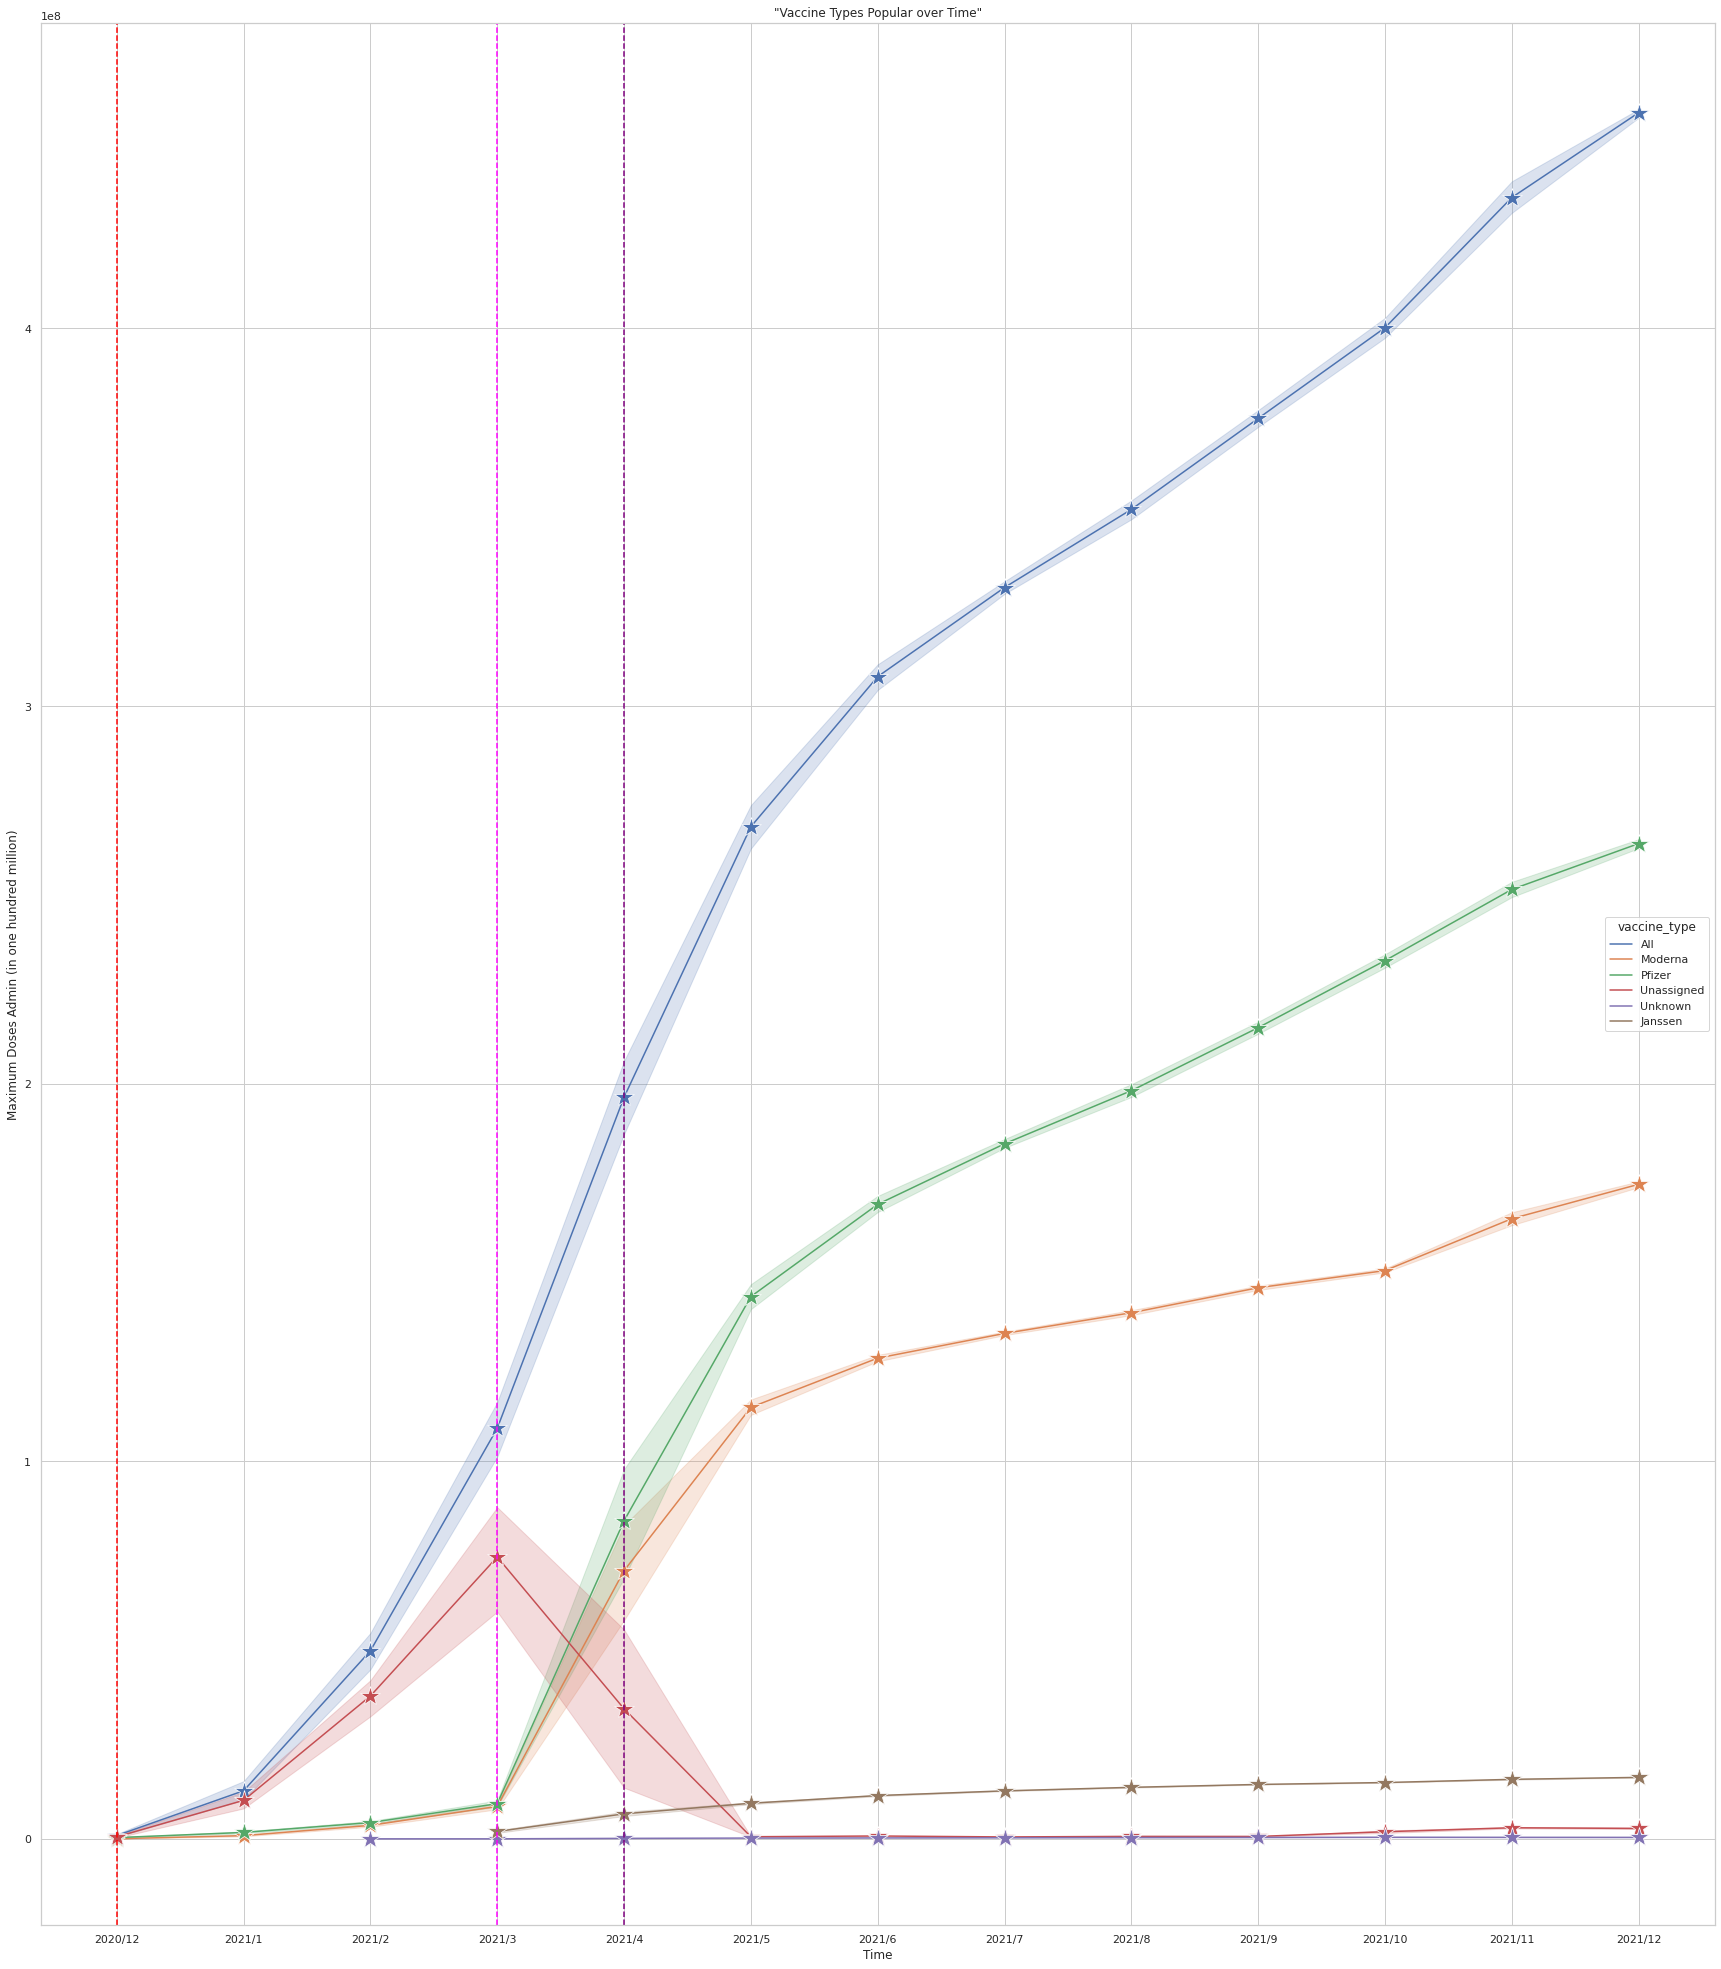

In [163]:
plt.figure(figsize = (30,35))
sns.set_theme(style="whitegrid")
plot = sns.lineplot(x="timeperiod", y="max_doses_administered", hue="vaccine_type", marker='*', ms=20, data=vaccine_1_pd)
plot.axvline('2020/12', color = 'red', linestyle = '--') # FDA approves both Morderna and Pfizer and the first deliveries of the COVID-19 vaccines began 
plot.axvline('2021/3', color = 'magenta', linestyle = '--') # FDA approves JnJ and and on March-02-2021 the Acting HHS Secretary directed that vaccination was avaible for teachers, school staff, and child care workers
plot.axvline('2021/4', color = '#800080', linestyle = '--') # on April 19 2021 White House COVID Response Team announced that all people age 16 and older are eligible for the COVID-19 vaccine
plt.xlabel('Time')
plt.ylabel("Maximum Doses Admin (in one hundred million)")
plt.title('"Vaccine Types Popular over Time"')
plot.legend
plt.savefig('vaccine.png')

##### About the graph:
 * The <span style="color:red">*red*</span> dashed vertical line represents the yyyy/mm of FDA approvals of both Morderna(December-20-2020) and Pfizer(December-13-2020 ) and on December-14-2020 the first deliveries of the COVID-19 vaccines began
 * The <span style="color:#FF00FF">*megenta*</span> dashed vertical line represents the yyyy/mm of FDA approval of JnJ(Feburary-27-2021) ~ 2021/3 and on March-02-2021 the Acting HHS Secretary directed that vaccination was avaible for teachers, school staff, and child care workers
 * The <span style="color:#800080">*purple*</span> dashed vertical line represents the yyyy/mm on April-19-2021 White House COVID Response Team announced that all people age 16 and older are eligible for the COVID-19 vaccine

##### Analysis:
   * A decline in the vaccine_type 'Unassigned' is observed after the FDA approves JnJ - here we can suggest that JnJ's clicnical trials ended and as such the number of drugs administered through the type 'Unassigned' reduced
   * The lines that represent Morderna and Pfizer have an exponential increase in the month of March 2021 - here we can suggest that this might be because the Acting HHS Secretary directed that vaccination was avaible for teachers, school staff, and child care workers 
   * We observe that Pfizer was more popular in the US when compared to Morderna and JnJ with about 2.6 hundred million doses being administered across the US
   * Morderna comes next with about 1.8 hundred million doses being adminstered and JnJ comes later with about 30 million doses being administered across the US